(165, 245, 3)
original video size for each color channels: 727650
done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(165, 245, 3)
psnr of comression: 8.2487


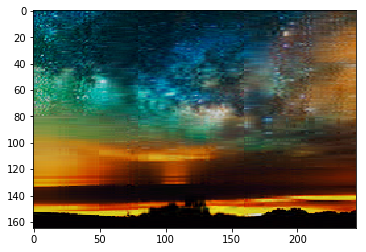

In [4]:
import sys
import os
script_path = os.path.abspath('')
module_path = script_path[:script_path.rfind('src')]+ 'src' + '/'
asset_path = script_path[:script_path.rfind('src')]+ 'asset' + '/'
sys.path.append(module_path)
from scipy import signal 
from scipy import ndimage, misc, interpolate
from struct import *
from utils.Helper_functions import *
import pca

buffer_path = asset_path + 'buffer.txt'

class CompressData:
    """
    This class contains methods for image/video compression

    attributes:
        bodyData
        headerData
        finalData
    """
    def __init__(self, filename):
        """
        Take the image pixel data nparry as input.
        """
        self.filepath = asset_path + filename
        self.buffer_path = buffer_path
        self.com_layer = 0
        self.recom_buffer = np.array([])
        self.recom_buffer = np.append(self.recom_buffer, self.filepath)
        # 'resample': 0, 'pca': 1
        format_table = TwoWayDict()
        format_table['resample'] = 0
        format_table['pca'] = 1
        self.format_table = format_table

    #-------------------------------------#
    # RESAMPLE
    #-------------------------------------#
#     def recompress(self, method ='resample', params={'factor_xy': 0.5, 'timeFlag': False, 'frame_rate': 10}):
#         self.com_layer+=1
#         self.recom_buffer = np.append(self.recom_buffer, asset_path + 'buffer' + str(self.com_layer) + '.txt')
#         temp_path = self.recom_buffer
#         self.compress(method, params)
        
        
    def compress(self, method = 'resample', params={'factor_xy': 0.5, 'timeFlag': False, 'frame_rate': 10}):
        self.method = method
        self.image_stack = imageStack_load(self.filepath)

        if method == 'resample':
            r, info = self.downsample(self.image_stack, params)
#             com_video_size = np.prod(r.shape)
            self.mainData = self.encode_resample(info, r.flatten())
        elif method == 'pca':
            pca_example=pca.PCA(self.image_stack)
            pca_example.procInput_noFlatten()
            compressedX=pca_example.getArraysToTransmit()
            encodingPCA=pca_example.encode_PCA(compressedX)
#             print(type(encodingPCA))
            self.mainData = encodingPCA
            
        # write the prefix and combine all handled data together and wirte to the file now
#         self.com_video_size = com_video_size
        self.encode()
        # save it to the file
        with open(self.buffer_path, 'bw+') as f_buffer:
            f_buffer.write(self.final_bits)        
    
    
    def decompress(self):
        # extract from buffer.txt by default
        self.decode()
        method = self.method
        if method == 'resample':
            # equal to decompress_resam
            inf, bodyDat = self.decode_resample()
            com_height = inf[5]
            com_width = inf[6]
            com_frames = inf[7]
            com_channels = inf[8]
            frame_rate = inf[9]
            recons = self.upsample(bodyDat.reshape(com_frames, com_height, com_width, com_channels), inf)
            # npArray_play(recons, frame_rate = 20)
            pixData = recons

        elif method == 'pca':
            decodedX,param=pca.decode_PCA(self.mainData)
            reconstructed=pca.pca_reconstruct(decodedX,param)
            npArray_play(reconstructed)
            pixData=reconstructed
#             print(pixData.shape)
            for i in range(pixData.shape[0]):
                plt.imshow(pixData[i])
            ########## TODO!!########
            frame_rate = 10

        # save np array to png image file
        # pngImg = Image.fromarray(pixData)
        # pngImg.save(asset_path+'/result.png')
        return pixData, frame_rate


    #-------------------------------------#
    # FILE CODING
    # this part only handle with already encoded file and add prefix and write it to file
    #-------------------------------------#
    def encode(self):
        # add prefix to our 
        prefix = pack('i', self.format_table[self.method])
        pre_length = pack('i', len(self.mainData))
        self.final_bits = prefix + self.mainData
#         print(self.final_bits[:200])

    def decode(self):
        # open and read file
        filename = self.buffer_path
        with open(filename, 'rb') as f_buffer:
            data = f_buffer.read()

        # extract the method
        # get remaining main data for further process
#         print(data[:200])
        format = unpack('i', data[0:4])
        mainLen = len(data)//4 - 1
        mainData = data[4:]

        self.method = self.format_table[format[0]]
        self.mainData = mainData

    #-------------------------------------#
    # PCA
    #-------------------------------------#


    #-------------------------------------#
    # JPEG
    #-------------------------------------#
    def JPEG(self):
        pass
    
    #-------------------------------------#
    # JPEG 2000
    #-------------------------------------#
    def JPEG2000(self):
        pass

    #-------------------------------------#
    # RESAMPLE
    #-------------------------------------#
    def encode_resample(self, info, bodyData):
        """
        to save the trouble from python bitstream, we'll use file as the buffer for transmission
        """
        # encode the origin_info
        new_info = [len(info)] + info
        header = pack('%sH' % len(new_info), *new_info)
        # flatten the numpy array and encode 
        dataVec = bodyData.tolist()
#         print(len(dataVec))
        body_header = pack('I', len(dataVec))
        # Judge if the len need to use long
        body = body_header + pack('%sH' % len(dataVec), *dataVec)  
        return header + body

    def decode_resample(self):
        data = self.mainData
        # decode the origin_info
        by_len = 2
        header_len = unpack('H', data[0:by_len])
        header_end_idx = by_len*header_len[0]+by_len
        info = unpack('%sH' % (header_len[0]), data[by_len: header_end_idx])
        # decode body
        body_start_idx = header_end_idx
        body_len = unpack('I', data[body_start_idx: body_start_idx + 4])
#         print(body_len[0])
        bodyData = np.array(unpack('%sH' % (body_len[0]), data[body_start_idx + 4:body_start_idx + 4 + by_len*body_len[0]]))
        return info, bodyData
        
    
    def downsample(self, npArray, params):
        """
        Params:
            timeFlag: whether or not downsample in t index, False by default
            factor_xy: only support float, if wrong type, use 100% by default. 
        Notice:
            If you want to use 100%, use 1.0 instead of 1!!
            we only support resample by 2 on time axis!!
        """

        factor_xy = params['factor_xy']
        timeFlag = params['timeFlag']
        frame_rate = params['frame_rate']

        if type(factor_xy) is not float:
            print("wrong sampling rate format!!!, continue with factor_xy = 1")
            factor_xy = 1.0
        
        if len(npArray.shape) == 3:
            ori_height= npArray.shape[0]
            ori_width = npArray.shape[1]
            ori_channels = npArray.shape[2]
            timeFlag = False
        else:
            ori_frames = npArray.shape[0]
            ori_height= npArray.shape[1]
            ori_width = npArray.shape[2]
            ori_channels = npArray.shape[3]
            
        height = int(ori_height*factor_xy)
        width = int(ori_width*factor_xy)
            
        data_xy = np.empty([ori_frames, height, width, ori_channels], dtype = 'uint8')
        for i in range(ori_frames):
            data_xy[i] = misc.imresize(npArray[i], factor_xy)
        
        # time axis
        if timeFlag:
            # downsample
            h_t = signal.firwin(ori_frames, 1/2)
            ndimage.convolve1d(data_xy, h_t, axis = 0)

            new_frames = int(np.ceil(ori_frames/2))
            data_t = np.empty([new_frames, height, width, ori_channels], dtype = 'uint8')

            for i in range(ori_frames):
                if i%2 == 0: 
                    data_t[i//2] = data_xy[i]
            result = data_t
            frames = new_frames
        else:
            result = data_xy
            frames = ori_frames

        origin_info = [ori_height, ori_width, ori_frames, ori_channels]
        compressed_info = [timeFlag, height, width, frames, ori_channels, frame_rate]
        info = origin_info+compressed_info
        
        return result, info


    def upsample(self, npArray, info):
        """    
        origin_info: list
        """
        frames = npArray.shape[0]
        height= npArray.shape[1]
        width = npArray.shape[2]
        channels = npArray.shape[3]
            
        ori_height = info[0]
        ori_width = info[1]
        ori_frames = info[2]
        ori_channels = info[3]
        timeFlag = info[4]
            
        data_t = np.empty([ori_frames, height, width, ori_channels], dtype = 'uint8')
        if timeFlag:
                # upsample
                for i in range(ori_frames):
                    if i%2 == 0:
                        data_t[i] = npArray[i//2]
                    else:
                        data_t[i] = np.zeros([height, width, channels], dtype = 'uint8')
                data_t = signal.resample(data_t, ori_frames, axis = 0, )                
        else:
            data_t = npArray

        result = np.empty([ori_frames, ori_height, ori_width, ori_channels], dtype = 'uint8')
        for i in range(ori_frames):
            result[i] = misc.imresize(data_t[i], [ori_height, ori_width])
        
        return result

    #-------------------------------------#
    # MPG
    #-------------------------------------#
    def MPG(self):
        pass

    #-------------------------------------#
    # Motion Vector
    #-------------------------------------#
    def MoVec(self):
        pass


if __name__ == "__main__":
    compressT = CompressData("milkyway.png")
    compressT.compress(method = "pca")
    ori_Data = compressT.image_stack

#     npArray_play(ori_Data, frame_rate = frame_rate)
    print(ori_Data[0].shape)


    

    # evaluate compression
#     com_size = compressT.com_video_size/3
    ori_size = np.prod(ori_Data.shape)/3
#     print("compressed video size for each color channels: %i" % com_size)
    print("original video size for each color channels: %i" % ori_size)
#     print("compression rate: %.3f" % (com_size/ori_size))

    compressR = CompressData("milkyway.png")
    result, frame_rate = compressR.decompress()
    
    print(result[0].shape)
#     npArray_play(result, frame_rate = frame_rate)
    # evaluate compression and transmission
    PSNR = psnr(ori_Data, result)
    print("psnr of comression: %.4f" % PSNR)



In [ ]:
a = [123, 2000000]
b = 2000000
# header = pack('%sH' % len(a), *a)
header1 = pack('H', a[0])
header2 = pack('I', a[1])
header = header1+header2
print(len(header))
print(header)

In [63]:
len_ = int(len(header)/2)
print(len_)
# a_1= unpack('%sH' % (len_), header)
a_1 = unpack('H', header[0:2])
a_2 = unpack('I', header[2:6])
# a = unpack('HI', header)
# print(a_[0] is a[0])
print(a_1)
print(a_2)

3
(123,)
(2000000,)


In [68]:
a=1
b = (a)

In [70]:
type(b)

int

In [74]:
a = np.array([])
a = np.append(a, "abc")
a = np.append(a, "abc")
a

array(['abc', 'abc'], dtype='<U32')